try to construct the network with treating country relationship as bipartite network

In [1]:
import pandas as pd
import numpy as np
from itertools import product
from ast import literal_eval
from itertools import combinations
from itertools import permutations
import networkx as nx
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import geopandas as gpd

In [2]:
cntry_flow=pd.read_csv("../../data/nf_folder/Data/DerivedData/Derived/funding_source_target.csv")
cntry_flow.head()

,source,target,value
0,Afghanistan,Afghanistan,0.500000
1,Afghanistan,Australia,0.333333
2,Afghanistan,Bangladesh,0.666667
3,Afghanistan,Bolivia,0.125000
4,Afghanistan,Canada,1.132576


In [3]:
cntry_flow=cntry_flow.query('source!=target')
cntry_flow.head()

,source,target,value
1,Afghanistan,Australia,0.333333
2,Afghanistan,Bangladesh,0.666667
3,Afghanistan,Bolivia,0.125000
4,Afghanistan,Canada,1.132576
5,Afghanistan,China,0.833333


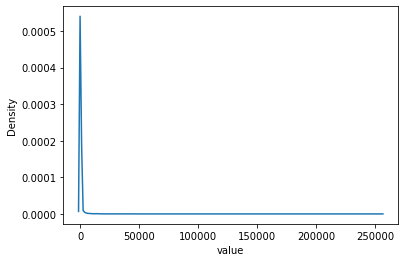

In [13]:
sns.kdeplot(x='value',data=cntry_flow)

In [12]:
cntry_flow.shape[0]/(len(sset)*len(tset))

0.35490265846591773

the first method of filtering network is to select the edge with largest weight of each node

In [8]:
network_filter=[]
cntrylist=cntry_flow['source'].unique()
for s in cntrylist:
    c_df= cntry_flow[cntry_flow.source==s]
    targets=c_df.sort_values(by='value',ascending=False)[:2]['target'].values
    for t in targets:
        network_filter.append([s,t])

In [9]:
nt_df=pd.DataFrame(network_filter,columns=['source','target'])
nt_df.head()

,source,target
0,Afghanistan,Nepal
1,Afghanistan,United States
2,Albania,Germany
3,Albania,Italy
4,Algeria,France


In [10]:
nt_df[nt_df.target=='Republic of Serbia']

,source,target
40,Bosnia & Herzegovina,Republic of Serbia
227,Montenegro,Republic of Serbia
278,Republic of Kosovo,Republic of Serbia


In [11]:
indegree=nt_df.groupby(['target']).size().reset_index(name='count')
indegree=indegree.sort_values(by='count',ascending=False)
indegree

,target,count
43,United States,131
42,United Kingdom,46
15,France,35
17,Germany,29
37,Spain,23
1,Australia,12
35,South Africa,11
21,Italy,7
33,Russia,7
8,China,7


In [8]:
indegree['count'].sum()

191

In [22]:
network = nx.from_pandas_edgelist(nt_df,create_using=nx.DiGraph)
nx.write_gexf(network,"network_MRS_deg2.gexf")

In [5]:
cntrylist = np.unique(cntry_flow[['source','target']].values.ravel())
world_total=cntry_flow['value'].sum()
resultlist=[]
for cntry_s, cntry_t in permutations(cntrylist,2):
    s2t=cntry_flow[(cntry_flow.source==cntry_s)&(cntry_flow.target==cntry_t)]['value'].sum()
    s_out=cntry_flow[(cntry_flow.source==cntry_s)]['value'].sum()
    t_in=cntry_flow[(cntry_flow.target==cntry_t)]['value'].sum()
    rca=(s2t/s_out)/(t_in/world_total)
    resultlist.append([cntry_s,cntry_t,rca])

<ipython-input-5-16fd05c14083>:8: RuntimeWarning: invalid value encountered in double_scalars
  rca=(s2t/s_out)/(t_in/world_total)


In [40]:
result_df=pd.DataFrame(resultlist,columns=['source','target','weight'])
result_df.head()

,source,target,weight
0,Afghanistan,Albania,0.0
1,Afghanistan,Algeria,0.0
2,Afghanistan,Andorra,0.0
3,Afghanistan,Angola,0.0
4,Afghanistan,Antarctica,0.0


In [41]:
result_df=result_df.dropna()
result_df.head()

,source,target,weight
0,Afghanistan,Albania,0.0
1,Afghanistan,Algeria,0.0
2,Afghanistan,Andorra,0.0
3,Afghanistan,Angola,0.0
4,Afghanistan,Antarctica,0.0


In [42]:
result_df['weight']=np.log10(result_df['weight'])
result_df

/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,source,target,weight
0,Afghanistan,Albania,-inf
1,Afghanistan,Algeria,-inf
2,Afghanistan,Andorra,-inf
3,Afghanistan,Angola,-inf
4,Afghanistan,Antarctica,-inf
...,...,...,...
42637,Zimbabwe,Vatican,-inf
42638,Zimbabwe,Venezuela,-inf
42639,Zimbabwe,Vietnam,0.266126
42640,Zimbabwe,Yemen,-inf


In [45]:
result_df = result_df[result_df['weight']!=-np.inf]

In [60]:
result_df.sort_values(by='weight',ascending=False)

,source,target,weight
12928,Fiji,Samoa,3.694474
34601,Solomon Islands,Vanuatu,3.691347
10557,Dominica,Dominican Republic,3.602800
38819,Trinidad and Tobago,Jamaica,3.510900
27248,Nicaragua,El Salvador,3.498600
...,...,...,...
5011,Brazil,Gambia,-3.166126
7742,Chile,Mongolia,-3.179564
1889,Australia,Chad,-3.195100
37684,Taiwan,Uganda,-3.316381


In [46]:
matrix=result_df.pivot_table(index='source',columns='target',values='weight',fill_value=-4)
matrix.head()

target,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua & Barbuda,Argentina,Armenia,Australia,...,United States,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
source,,,,,,,,,,,,,,,,,,,,,
Afghanistan,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.000000,-4.0,-0.376510,...,-0.250546,-4.0,-4.0,-4.0,-4.0,-4.0,1.115528,-4.000000,-4.0,-4.0
Albania,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.000000,-4.0,-0.504334,...,-0.660774,-4.0,-4.0,-4.0,-4.0,-4.0,1.367915,-4.000000,-4.0,-4.0
Algeria,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-0.106857,-4.0,-1.201195,...,-0.873321,-4.0,-4.0,-4.0,-4.0,-4.0,-0.787879,0.572866,-4.0,-4.0
Andorra,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.000000,-4.0,-4.000000,...,-0.363489,-4.0,-4.0,-4.0,-4.0,-4.0,-4.000000,-4.000000,-4.0,-4.0
Angola,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.000000,-4.0,0.132384,...,-0.447015,-4.0,-4.0,-4.0,-4.0,-4.0,-4.000000,-4.000000,-4.0,-4.0


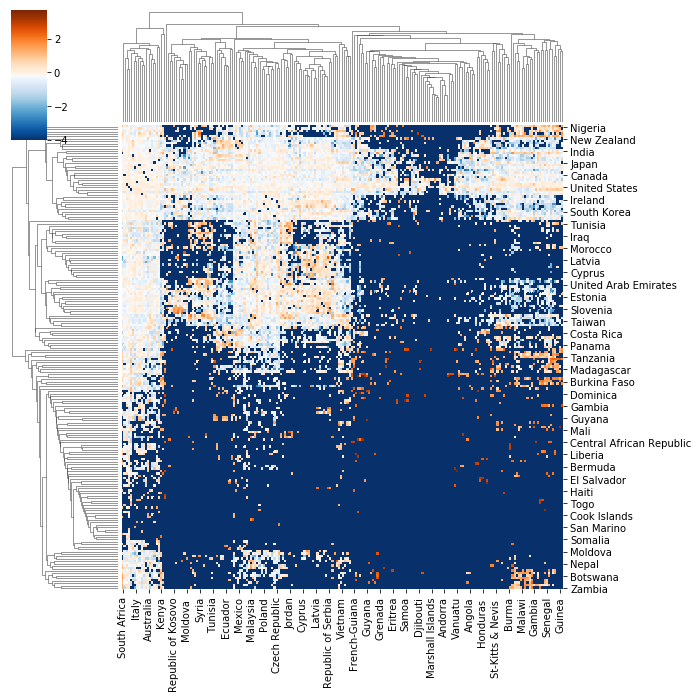

In [113]:
top = cm.get_cmap('Oranges', 128)
bottom = cm.get_cmap('Blues_r', 128)

newcolors = np.vstack((bottom(np.linspace(0, 1, 128)),
                       top(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


g = sns.clustermap(matrix,cmap=newcmp)
ax = g.ax_heatmap
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("funding_flow_rca_matrix.png",bbox_inches='tight')

In [59]:
cntrynum = len(np.unique(result_df[['source','target']].values.ravel()))
density=(result_df.shape[0])/(cntrynum*(cntrynum-1))
density

0.3274705689226584

In [75]:
import leidenalg as la
import igraph as ig

In [76]:
network_df['weight']=1

<ipython-input-76-b63f61ee50ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  network_df['weight']=1


In [77]:
tuples = [tuple(x) for x in network_df.values]
g = ig.Graph.TupleList(tuples, directed = True, edge_attrs = ['weight'])

In [79]:
group=la.find_partition(g,la.ModularityVertexPartition,weights='weight',
n_iterations=100)

resultlist=[]
for v in g.vs:
    resultlist.append([v['name'],group.membership[v.index]])
rdf=pd.DataFrame(resultlist,columns=['country','group'])

In [91]:
groupdict = dict(zip(rdf.country,rdf.group))

In [87]:
network_df

,source,target,weight
13,Afghanistan,Bangladesh,1
20,Afghanistan,Bolivia,1
32,Afghanistan,Canada,1
82,Afghanistan,India,1
84,Afghanistan,Iran,1
...,...,...,...
42625,Zimbabwe,Tunisia,1
42629,Zimbabwe,Uganda,1
42631,Zimbabwe,United Arab Emirates,1
42639,Zimbabwe,Vietnam,1


In [88]:
network = nx.from_pandas_edgelist(network_df,create_using=nx.DiGraph,edge_attr=True)

In [92]:
nx.set_node_attributes(network, groupdict, "community")

In [99]:
nx.write_gexf(network,"network_rca.gexf")

investigate the temporal change of network

In [4]:
cntry_flow_ann=pd.read_csv("../../data/nf_folder/Data/DerivedData/Derived/funding_source_target_dis.csv")
cntry_flow_ann.head()

,source,target,year,discipline,unit
0,Afghanistan,Afghanistan,2010,66,0.500000
1,Afghanistan,Australia,2018,69,0.333333
2,Afghanistan,Bangladesh,2011,47,0.666667
3,Afghanistan,Bolivia,2016,71,0.125000
4,Afghanistan,Canada,2015,71,0.333333


In [6]:
cntry_flow=cntry_flow_ann.groupby(['source','target'])['unit'].sum().reset_index()
cntry_flow.head()

,source,target,unit
0,Afghanistan,Afghanistan,0.500000
1,Afghanistan,Australia,0.333333
2,Afghanistan,Bangladesh,0.666667
3,Afghanistan,Bolivia,0.125000
4,Afghanistan,Canada,1.132576


In [8]:
cntry_flow=cntry_flow.query('source!=target')
cntry_flow.head()

,source,target,unit
1,Afghanistan,Australia,0.333333
2,Afghanistan,Bangladesh,0.666667
3,Afghanistan,Bolivia,0.125000
4,Afghanistan,Canada,1.132576
5,Afghanistan,China,0.833333


In [9]:
def get_network(data):
    flow_df=data.copy()
    cntrylist = np.unique(flow_df[['source','target']].values.ravel())
    world_total=flow_df['unit'].sum()
    resultlist=[]
    for cntry_s, cntry_t in permutations(cntrylist,2):
        s2t=flow_df[(flow_df.source==cntry_s)&(flow_df.target==cntry_t)]['unit'].sum()
        s_out=flow_df[(flow_df.source==cntry_s)]['unit'].sum()
        t_in=flow_df[(flow_df.target==cntry_t)]['unit'].sum()
        rca=(s2t/s_out)/(t_in/world_total)
        resultlist.append([cntry_s,cntry_t,rca])
    result_df=pd.DataFrame(resultlist, columns=['source','target','weight'])
    network_df=result_df[result_df.weight>1]
    return network_df

In [192]:
def get_out_in(network_df,year):
    out_df=network_df.groupby('source').size().reset_index()
    out_df.columns=['cntry','out']
    in_df=network_df.groupby('target').size().reset_index()
    in_df.columns=['cntry','in']
    deg=out_df.merge(in_df,on='cntry')
    deg['year']=year
    return deg

In [193]:
yearlist=cntry_flow_ann.year.unique()
deg_ann=pd.DataFrame()
for year in yearlist:
    network=get_network(cntry_flow_ann,year)
    deg=get_out_in(network,year)
    deg_ann=pd.concat([deg_ann,deg])


<ipython-input-191-6673dddb37a3>:10: RuntimeWarning: invalid value encountered in double_scalars
  rca=(s2t/s_out)/(t_in/world_total)
<ipython-input-191-6673dddb37a3>:10: RuntimeWarning: invalid value encountered in double_scalars
  rca=(s2t/s_out)/(t_in/world_total)
<ipython-input-191-6673dddb37a3>:10: RuntimeWarning: invalid value encountered in double_scalars
  rca=(s2t/s_out)/(t_in/world_total)
<ipython-input-191-6673dddb37a3>:10: RuntimeWarning: invalid value encountered in double_scalars
  rca=(s2t/s_out)/(t_in/world_total)
<ipython-input-191-6673dddb37a3>:10: RuntimeWarning: invalid value encountered in double_scalars
  rca=(s2t/s_out)/(t_in/world_total)
<ipython-input-191-6673dddb37a3>:10: RuntimeWarning: invalid value encountered in double_scalars
  rca=(s2t/s_out)/(t_in/world_total)
<ipython-input-191-6673dddb37a3>:10: RuntimeWarning: invalid value encountered in double_scalars
  rca=(s2t/s_out)/(t_in/world_total)
<ipython-input-191-6673dddb37a3>:10: RuntimeWarning: invalid v

In [204]:
deg_ann.head()

,cntry,out,in,year
0,Afghanistan,6,10,2018
1,Albania,6,15,2018
2,Algeria,23,29,2018
3,Andorra,4,2,2018
4,Angola,2,9,2018


In [209]:
cntry_out_ann=cntry_flow_ann.groupby(['source','year'])['unit'].sum().reset_index()
cntry_out_ann = cntry_out_ann[cntry_out_ann.source!='EU']
top15 = cntry_out_ann[cntry_out_ann.year==2018].sort_values(by='unit',ascending=False).head(10)['source'].values
top15

array(['United States', 'China', 'United Kingdom', 'Germany', 'Spain',
       'Canada', 'France', 'Japan', 'Brazil', 'Australia'], dtype=object)

In [210]:
top15_df=deg_ann[deg_ann.cntry.isin(top15)]
top15_df

,cntry,out,in,year
7,Australia,58,33,2018
22,Brazil,43,41,2018
31,Canada,51,23,2018
34,China,34,19,2018
53,France,82,66,2018
...,...,...,...,...
48,Germany,67,47,2009
67,Japan,35,22,2009
125,Spain,48,30,2009
142,United Kingdom,75,55,2009


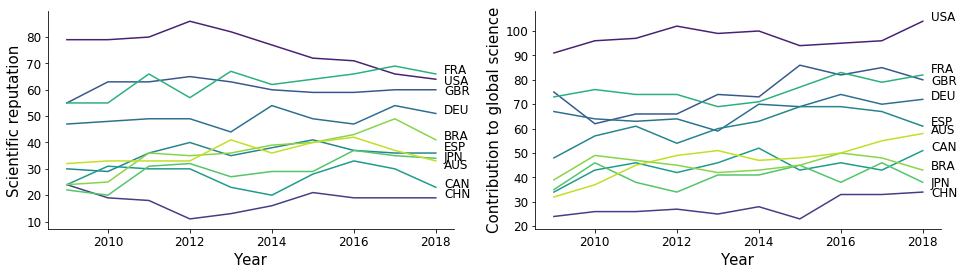

In [261]:
fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(16,4))
sns.lineplot(x='year',y='in',data=top15_df,hue='cntry',hue_order=top15,legend=False,palette='viridis',ax=ax[0])
ax[0].text(2018.2,66,'FRA',fontsize=12)
ax[0].text(2018.2,62,'USA',fontsize=12)
ax[0].text(2018.2,58,'GBR',fontsize=12)
ax[0].text(2018.2,51,'DEU',fontsize=12)
ax[0].text(2018.2,41,'BRA',fontsize=12)
ax[0].text(2018.2,37,'ESP',fontsize=12)
ax[0].text(2018.2,33,'JPN',fontsize=12)
ax[0].text(2018.2,30,'AUS',fontsize=12)
ax[0].text(2018.2,23,'CAN',fontsize=12)
ax[0].text(2018.2,19,'CHN',fontsize=12)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
sns.lineplot(x='year',y='out',data=top15_df,hue='cntry',hue_order=top15,legend=False,palette='viridis',ax=ax[1])
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].text(2018.2,104,'USA',fontsize=12)
ax[1].text(2018.2,83,'FRA',fontsize=12)
ax[1].text(2018.2,78,'GBR',fontsize=12)
ax[1].text(2018.2,72,'DEU',fontsize=12)
ax[1].text(2018.2,43,'BRA',fontsize=12)
ax[1].text(2018.2,61,'ESP',fontsize=12)
ax[1].text(2018.2,36,'JPN',fontsize=12)
ax[1].text(2018.2,58,'AUS',fontsize=12)
ax[1].text(2018.2,51,'CAN',fontsize=12)
ax[1].text(2018.2,32,'CHN',fontsize=12)
ax[1].tick_params(labelsize=12)
ax[0].tick_params(labelsize=12)
ax[1].set_xlabel("Year",fontsize=15)
ax[0].set_xlabel("Year",fontsize=15)
ax[1].set_ylabel("Contribution to global science",fontsize=15)
ax[0].set_ylabel("Scientific reputation",fontsize=15)
plt.savefig("in_out.png",bbox_inches='tight')

In [250]:
top15_df[top15_df.year==2018].sort_values(by='out',ascending=False)

,cntry,out,in,year
168,United States,104,64,2018
53,France,82,66,2018
167,United Kingdom,80,60,2018
59,Germany,72,51,2018
147,Spain,61,36,2018
7,Australia,58,33,2018
31,Canada,51,23,2018
22,Brazil,43,41,2018
78,Japan,38,34,2018
34,China,34,19,2018


In [177]:
test = get_network(cntry_flow_ann,2018)

<ipython-input-127-02f0e7fb8dca>:10: RuntimeWarning: invalid value encountered in double_scalars
  rca=(s2t/s_out)/(t_in/world_total)


In [178]:
a='Japan'
b='United States'
test[(test.source==a)&(test.target==b)]

,source,target,weight
18666,Japan,United States,1.503918


In [179]:
year=2018
at = cntry_flow_ann[(cntry_flow_ann.source==a)&(cntry_flow_ann.year==year)]['unit'].sum()
a2b = cntry_flow_ann[(cntry_flow_ann.source==a)&(cntry_flow_ann.target==b)&(cntry_flow_ann.year==year)]['unit'].values[0]
tb=cntry_flow_ann[(cntry_flow_ann.target==b)&(cntry_flow_ann.year==year)]['unit'].sum()
tt=cntry_flow_ann[(cntry_flow_ann.year==year)]['unit'].sum()
tt

694940.4369804625

In [181]:
(a2b/at)/(tb/tt)

1.5039176113972976

In [186]:
test[(test.weight>1)&(test.target=='United States')].shape

(64, 3)

In [180]:
cntry_flow_ann[(cntry_flow_ann.year==2018)&(cntry_flow_ann.source=='China')].sort_values(
by='unit',ascending=False)

,source,target,year,unit
14758,China,United States,2018,47029.817109
14748,China,United Kingdom,2018,10444.330740
13443,China,Australia,2018,10152.522647
13633,China,Canada,2018,6825.890936
13859,China,Germany,2018,5875.038494
...,...,...,...,...
13839,China,Gambia,2018,0.160038
14211,China,Monaco,2018,0.068098
14376,China,Paraguay,2018,0.047619
13906,China,Haiti,2018,0.041667
